In [ ]:
# @title
!pip install -r https://raw.githubusercontent.com/LizaAmatya/FakeNewsDetection/main/requirements.txt?token=GHSAT0AAAAAACJI6OXTY5SAB4ACBMT2IEH2ZLJCTFQ

In [ ]:
!pip install matplotlib

In [ ]:
# @title
import os
import pandas as pd
import tensorflow as tf
# import tensorflow_text
from transformers import BertTokenizer, TFBertForSequenceClassification, DistilBertTokenizer, TFDistilBertForSequenceClassification
from tensorflow.keras.utils import to_categorical
import numpy as np
from tensorflow.keras.layers import Input


In [ ]:
# os.environ["TF_AUTOTUNE"] = "1"
# tf.keras.backend.set_floatx('float16')
mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1","/gpu:2", "/gpu:3"])

In [ ]:
# try:
#   tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
#   print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
# except ValueError:
#   raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

# tf.config.run_functions_eagerly(True)
# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)
# tpu_strategy = tf.distribute.TPUStrategy(tpu)
# print("All devices: ", tf.config.list_logical_devices())

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# BASE_DIR = os.path.dirname(os.path.abspath(__file__))
BASE_DIR = "/content/sample_data"

In [ ]:
train_path = os.path.join(BASE_DIR, 'dataset/train.tsv')
test_path = os.path.join(BASE_DIR, 'dataset/test.tsv')
validation_path = os.path.join(BASE_DIR, 'dataset/validation.tsv')

In [ ]:
column_labels = ['row', 'json_ids', 'label', 'statement', 'subject', 'speaker', 'job_title', 'state', 'affiliation', 'barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'lies_counts', 'context', 'justification']

In [ ]:
# Data Frames
train = pd.read_csv(train_path, sep="\t", header=None, names=column_labels)
test = pd.read_csv(test_path, sep="\t", header=None, names=column_labels)
valid = pd.read_csv(validation_path, sep="\t", header=None, names=column_labels)

In [ ]:
# Fill nan (empty boxes) with 0
train = train.fillna('None')
test = test.fillna('None')
val = valid.fillna('None')


In [ ]:
labels = train['label']
label_mapping = {label: idx for idx, label in enumerate(labels.unique())}
label_mapping.update({'pants-fire':5})

num_of_classes=len(label_mapping)


In [ ]:
train['label_encoded'] = train['label'].map(label_mapping)

In [ ]:
val['label_encoded'] = val['label'].map(label_mapping)

In [ ]:
# model_name = 'bert-base-uncased'
model_name = 'distilbert-base-uncased'
# tokenizer = BertTokenizer.from_pretrained(model_name, max_length=128)
tokenizer = DistilBertTokenizer.from_pretrained(model_name, max_length=128)


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
# Tokenize statement and metadata
train_encoded_statement_data = tokenizer(
    train['statement'].to_list(),
    padding='max_length',
    truncation=True,
    max_length=128,
    return_tensors='tf'
)
train['metadata'] = train['subject'].astype(str) + ' ' + train['speaker'].astype(str) + ' ' + train['job_title'].astype(str) + ' ' + train['state'].astype(str) + ' ' + train['affiliation'].astype(str) + ' ' + train['context'].astype(str)

train_encoded_metadata = tokenizer(
    train['metadata'].to_list(),
    padding='max_length',
    truncation=True,
    max_length=128,
    return_tensors='tf'
)

# print(train_encoded_statement_data['input_ids'].shape)
# print(train_encoded_metadata['input_ids'].shape)

In [ ]:
val_encoded_statement_data = tokenizer(
    val['statement'].tolist(),
    padding='max_length',
    truncation=True,
    max_length=128,
    return_tensors='tf'
)
val['metadata'] = val['subject'].astype(str) + ' ' + val['speaker'].astype(str) + ' ' + val['job_title'].astype(str) + ' ' + val['state'].astype(str) + ' ' + val['affiliation'].astype(str) + ' ' + val['context'].astype(str)

val_encoded_metadata = tokenizer(
    val['metadata'].to_list(),
    padding='max_length',
    truncation=True,
    max_length=128,
    return_tensors='tf'
)
# print(val_encoded_statement_data['input_ids'].shape)
# print(val_encoded_metadata['input_ids'].shape)

In [ ]:
# Create TensorFlow dataset for training
train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': train_encoded_statement_data['input_ids'],
        'attention_mask': train_encoded_statement_data['attention_mask'],
        'input_ids_metadata': train_encoded_metadata['input_ids'],
        'attention_mask_metadata': train_encoded_metadata['attention_mask']
    },
    train['label_encoded'] ))  # using one-hot encoded labels when CategoricalCrossEntropy used,
                            # and when using SparseCrossEntropy use train['label_encoded'] which is int rep for labels : 0, 1, 2 ..5

In [ ]:
val_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': val_encoded_statement_data['input_ids'],
        'attention_mask': val_encoded_statement_data['attention_mask'],
        'input_ids_metadata': val_encoded_metadata['input_ids'],
        'attention_mask_metadata': val_encoded_metadata['attention_mask']

    },
    val['label_encoded'] ))  # using one-hot encoded labels when CategoricalCrossEntropy used,
                            # and when using SparseCrossEntropy use train['label_encoded'] which is int rep for labels : 0, 1, 2 ..5

In [ ]:
# Creating model with BERT
max_length = 128
def create_bert_model():
    model_name = 'distilbert-base-uncased'
    model = TFDistilBertForSequenceClassification.from_pretrained(model_name)

    # Define input layers
    input_ids_statement = Input(shape=(max_length,), dtype=tf.int32, name='input_ids')
    attention_mask_statement = Input(shape=(max_length,), dtype=tf.int32, name='attention_mask')
    input_ids_metadata = Input(shape=(max_length,), dtype=tf.int32, name='input_ids_metadata')
    attention_mask_metadata = Input(shape=(max_length,), dtype=tf.int32, name='attention_mask_metadata')

    bert_output_statement = model([input_ids_statement, attention_mask_statement])
    bert_output_metadata = model([input_ids_metadata, attention_mask_metadata])

    # Add dense layers for classification on each branch
    dense_layer_statement = tf.keras.layers.Dense(256, activation='relu')(bert_output_statement.logits)
    dense_layer_metadata = tf.keras.layers.Dense(256, activation='relu')(bert_output_metadata.logits)

    # Merge the outputs using Concatenate or other merging strategies
    merged_output = tf.keras.layers.Concatenate(axis=-1)([dense_layer_statement, dense_layer_metadata])

    # Add additional dense layers for classification
    final_dense_layer = tf.keras.layers.Dense(128, activation='relu')(merged_output)
    output = tf.keras.layers.Dense(num_of_classes, activation='softmax')(final_dense_layer)

    custom_model = tf.keras.Model(inputs=[input_ids_statement, attention_mask_statement, input_ids_metadata, attention_mask_metadata], outputs=output)
    custom_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            metrics=tf.keras.metrics.SparseCategoricalAccuracy())  # or use ['accuracy']

    return custom_model


In [ ]:
def create_model():
  model_name = 'distilbert-base-uncased'
  model = TFDistilBertForSequenceClassification.from_pretrained(model_name)
  input_ids = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='input_ids')
  attention_mask = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='attention_mask')

  bert_output = model([input_ids, attention_mask])
  cls_token = bert_output.logits

  # Adding a dropout layer
  dropout_rate = 0.5  # Adjust the dropout rate as needed
  dropout_layer = tf.keras.layers.Dropout(rate=dropout_rate, name='dropout')(cls_token)

  # Adding a dense layer for the output
  dense_layer = tf.keras.layers.Dense(num_of_classes, activation='softmax', name='dense_output')
  dense_output = dense_layer(dropout_layer)
  # dense_output_expanded = tf.keras.layers.Reshape((1, 6))(dense_output)

  output = tf.keras.layers.Dense(num_of_classes, activation='softmax')(dense_output)

  custom_model = tf.keras.Model(inputs=model.input, outputs=output)
  custom_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(),        #Use of SparseCategoricalCrossEntropy for multiple classes
            metrics=tf.keras.metrics.SparseCategoricalAccuracy())  # or use ['accuracy']

  return custom_model

In [ ]:
num_epochs = 10
batch_size = 32

In [ ]:

strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    custom_model = create_bert_model()
# with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
#   custom_model = create_model()

custom_model.summary()
# for layer in custom_model.layers:
#     print(layer.name, layer.input_shape, layer.output_shape)
# print(custom_model.input)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 128)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 input_ids_metadata (InputL  [(None, 128)]                0         []                            
 ayer)                                                                                            
                                                                                              

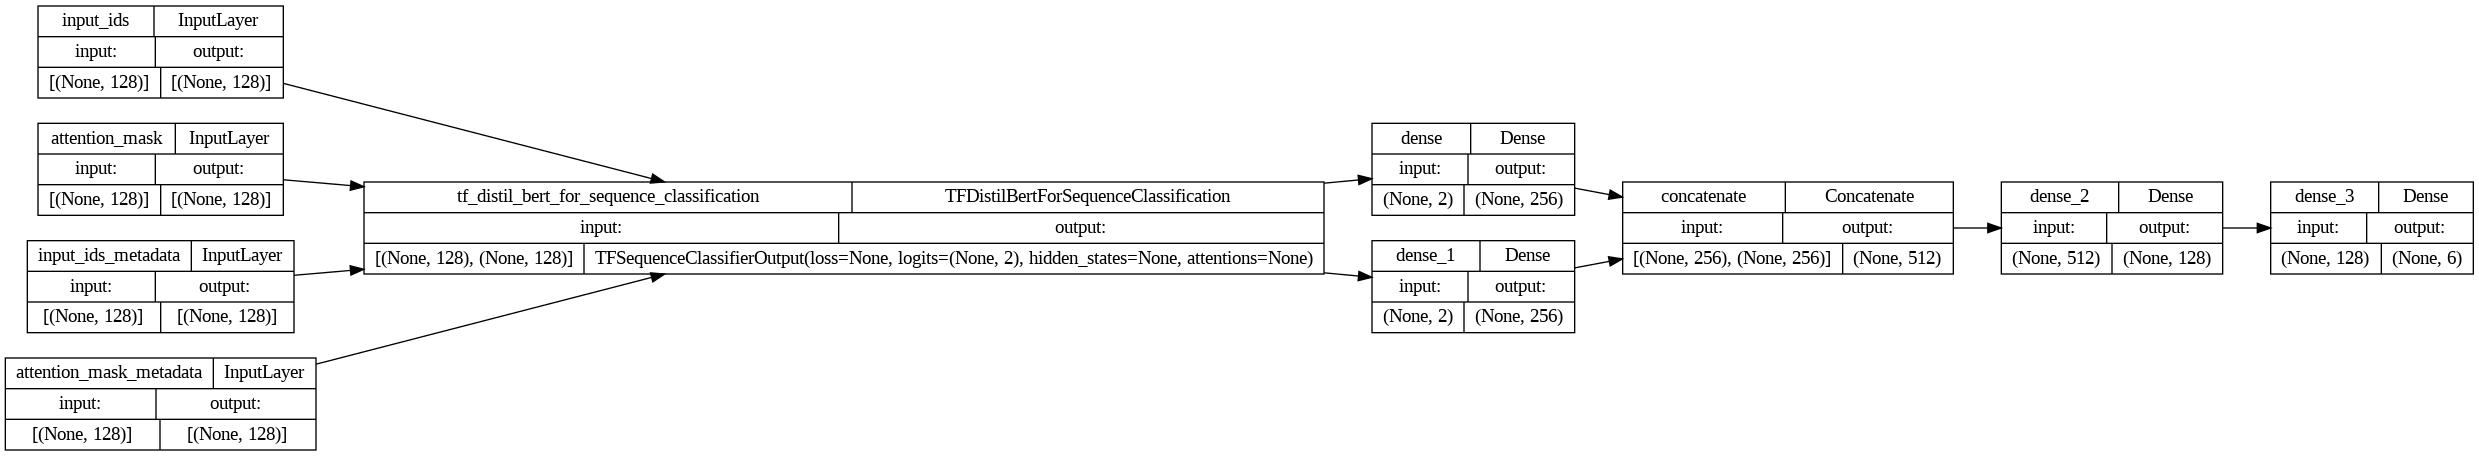

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(custom_model, to_file='custom_model.png', show_shapes=True, show_layer_names=True)

# If you want to save separate images for train, validation, and test datasets
plot_model(custom_model, to_file='train_model.png', show_shapes=True, show_layer_names=True, rankdir='LR')
plot_model(custom_model, to_file='validation_model.png', show_shapes=True, show_layer_names=True, rankdir='LR')
plot_model(custom_model, to_file='test_model.png', show_shapes=True, show_layer_names=True, rankdir='LR')

In [ ]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(BASE_DIR, 'model_checkpoint'),  # Specify the path to save the checkpoint
    save_best_only=True,  # Save only the best model based on the validation loss
    monitor='val_loss',  # Monitor the validation loss
    mode='min',  # Mode can be 'min' or 'max' depending on the monitored metric
    verbose=1  # Show progress while saving
)

In [ ]:
from tqdm import tqdm
from tensorflow.keras.callbacks import Callback

train_steps_per_epoch = len(train_dataset)
tqdm_callback = tf.keras.callbacks.LambdaCallback(
    on_epoch_begin=lambda epoch, logs: tqdm(total=train_steps_per_epoch, position=0, desc="Epoch", unit="batch"),
    on_epoch_end=lambda epoch, logs: tqdm.write(f'Epoch {epoch + 1}/{num_epochs}, Loss: {logs["loss"]}, Accuracy: {logs["sparse_categorical_accuracy"]}, Val Loss: {logs["val_loss"]}, Val Accuracy: {logs["val_sparse_categorical_accuracy"]}'),
    on_batch_end=lambda batch, logs: tqdm.update(1)
)

class ProgressBarCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.epochs += 1
        self.pbar.update(1)
        self.pbar.set_postfix(logs, refresh=True)

    def on_train_begin(self, logs=None):
        self.epochs = 0
        self.pbar = tqdm(total=self.params['epochs'], unit='epoch', position=0)

    def on_train_end(self, logs=None):
        self.pbar.close()

In [ ]:
print('Start training')
progress_bar_callback = ProgressBarCallback()
history = custom_model.fit(
    train_dataset.shuffle(10000).batch(batch_size).prefetch(tf.data.AUTOTUNE),
    epochs=num_epochs,
    validation_data=val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE),
    verbose=2,
    callbacks=[checkpoint_callback, progress_bar_callback]
)

Start training


  0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch 1/10

Epoch 1: val_loss improved from inf to 1.76400, saving model to /content/sample_data/model_checkpoint


 10%|█         | 1/10 [05:06<46:00, 306.75s/epoch, loss=1.76, sparse_categorical_accuracy=0.197, val_loss=1.76, val_sparse_categorical_accuracy=0.193]

320/320 - 307s - loss: 1.7633 - sparse_categorical_accuracy: 0.1970 - val_loss: 1.7640 - val_sparse_categorical_accuracy: 0.1931 - 307s/epoch - 958ms/step
Epoch 2/10

Epoch 2: val_loss improved from 1.76400 to 1.76234, saving model to /content/sample_data/model_checkpoint


 20%|██        | 2/10 [09:45<38:39, 289.99s/epoch, loss=1.76, sparse_categorical_accuracy=0.2, val_loss=1.76, val_sparse_categorical_accuracy=0.193]  

320/320 - 278s - loss: 1.7589 - sparse_categorical_accuracy: 0.2001 - val_loss: 1.7623 - val_sparse_categorical_accuracy: 0.1931 - 278s/epoch - 869ms/step
Epoch 3/10

Epoch 3: val_loss did not improve from 1.76234


 30%|███       | 3/10 [13:52<31:32, 270.36s/epoch, loss=1.76, sparse_categorical_accuracy=0.206, val_loss=1.76, val_sparse_categorical_accuracy=0.205]

320/320 - 247s - loss: 1.7586 - sparse_categorical_accuracy: 0.2062 - val_loss: 1.7646 - val_sparse_categorical_accuracy: 0.2048 - 247s/epoch - 772ms/step
Epoch 4/10

Epoch 4: val_loss did not improve from 1.76234


 40%|████      | 4/10 [17:58<26:06, 261.12s/epoch, loss=1.76, sparse_categorical_accuracy=0.201, val_loss=1.76, val_sparse_categorical_accuracy=0.193]

320/320 - 247s - loss: 1.7584 - sparse_categorical_accuracy: 0.2012 - val_loss: 1.7637 - val_sparse_categorical_accuracy: 0.1931 - 247s/epoch - 771ms/step
Epoch 5/10

Epoch 5: val_loss improved from 1.76234 to 1.76184, saving model to /content/sample_data/model_checkpoint


 50%|█████     | 5/10 [22:36<22:15, 267.20s/epoch, loss=1.76, sparse_categorical_accuracy=0.205, val_loss=1.76, val_sparse_categorical_accuracy=0.193]

320/320 - 278s - loss: 1.7577 - sparse_categorical_accuracy: 0.2046 - val_loss: 1.7618 - val_sparse_categorical_accuracy: 0.1931 - 278s/epoch - 868ms/step
Epoch 6/10

Epoch 6: val_loss did not improve from 1.76184


 60%|██████    | 6/10 [27:27<18:20, 275.16s/epoch, loss=1.76, sparse_categorical_accuracy=0.206, val_loss=1.77, val_sparse_categorical_accuracy=0.193]

320/320 - 247s - loss: 1.7576 - sparse_categorical_accuracy: 0.2064 - val_loss: 1.7656 - val_sparse_categorical_accuracy: 0.1931 - 247s/epoch - 771ms/step
Epoch 7/10

Epoch 7: val_loss did not improve from 1.76184


 70%|███████   | 7/10 [31:49<13:32, 270.93s/epoch, loss=1.76, sparse_categorical_accuracy=0.205, val_loss=1.77, val_sparse_categorical_accuracy=0.193]

320/320 - 247s - loss: 1.7579 - sparse_categorical_accuracy: 0.2052 - val_loss: 1.7655 - val_sparse_categorical_accuracy: 0.1931 - 247s/epoch - 771ms/step
Epoch 8/10

Epoch 8: val_loss did not improve from 1.76184


 80%|████████  | 8/10 [35:56<08:46, 263.22s/epoch, loss=1.76, sparse_categorical_accuracy=0.204, val_loss=1.76, val_sparse_categorical_accuracy=0.193]

320/320 - 247s - loss: 1.7579 - sparse_categorical_accuracy: 0.2043 - val_loss: 1.7640 - val_sparse_categorical_accuracy: 0.1931 - 247s/epoch - 771ms/step
Epoch 9/10

Epoch 9: val_loss did not improve from 1.76184


 90%|█████████ | 9/10 [40:03<04:18, 258.11s/epoch, loss=1.76, sparse_categorical_accuracy=0.206, val_loss=1.76, val_sparse_categorical_accuracy=0.205]

320/320 - 247s - loss: 1.7576 - sparse_categorical_accuracy: 0.2061 - val_loss: 1.7625 - val_sparse_categorical_accuracy: 0.2048 - 247s/epoch - 771ms/step
Epoch 10/10

Epoch 10: val_loss did not improve from 1.76184


100%|██████████| 10/10 [44:09<00:00, 254.55s/epoch, loss=1.76, sparse_categorical_accuracy=0.205, val_loss=1.76, val_sparse_categorical_accuracy=0.193]

320/320 - 246s - loss: 1.7576 - sparse_categorical_accuracy: 0.2051 - val_loss: 1.7649 - val_sparse_categorical_accuracy: 0.1931 - 246s/epoch - 770ms/step


100%|██████████| 10/10 [44:09<00:00, 264.99s/epoch, loss=1.76, sparse_categorical_accuracy=0.205, val_loss=1.76, val_sparse_categorical_accuracy=0.193]


In [ ]:
# Save the trained model if needed
custom_model.save(os.path.join(BASE_DIR, 'trained_model'))

In [ ]:
from keras.utils import Progbar

# Tokenize and preprocess the test data
test_encoded_statement_data = tokenizer(
    test['statement'].tolist(),
    padding=True,
    truncation=True,
    return_tensors='tf'
)
test['label_encoded'] = test['label'].map(label_mapping)
test['metadata'] = test['subject'].astype(str) + ' ' + test['speaker'].astype(str) + ' ' + test['job_title'].astype(str) + ' ' + test['state'].astype(str) + ' ' + test['affiliation'].astype(str) + ' ' + test['context'].astype(str)

test_encoded_metadata = tokenizer(
    test['metadata'].to_list(),
    padding=True,
    truncation=True,
    max_length=128,
    return_tensors='tf'
)

# Create TensorFlow dataset for testing
test_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': test_encoded_statement_data['input_ids'],
        'attention_mask': test_encoded_statement_data['attention_mask'],
        'input_ids_metadata': test_encoded_metadata['input_ids'],
        'attention_mask_metadata': test_encoded_metadata['attention_mask']
    },
    test['label_encoded']
))
# limited_test_dataset = test_dataset.take(limit)
test_steps = len(test_dataset)
progbar = Progbar(test_steps)

# Evaluate the model on the test dataset
with strategy.scope():
  results = custom_model.evaluate(test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE))

# Display the results and update the progress bar
for metric_name, result in zip(custom_model.metrics_names, results):
    print(f'{metric_name}: {result}')

    # Update progress bar
    progbar.update(1)
# Print the evaluation results (including accuracy)
print("Test Loss:", results[0])
print("Test Accuracy:", results[1])



40/40 [==============================] - 21s 422ms/step - loss: 1.7506 - sparse_categorical_accuracy: 0.2082
loss: 1.750599980354309
   1/1268 [..............................] - ETA: 7:15:01sparse_categorical_accuracy: 0.20820190012454987
Test Loss: 1.750599980354309
Test Accuracy: 0.20820190012454987


In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.plot(epochs, results[1])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss/Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()